In [1]:
import os
#virtually move to parent directory
os.chdir("..")

import torch
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

import utils
import similarity
from experiments import fig_1_7_8_colorings

In [2]:
#Arguments
clip_name = 'ViT-B/16'#"ViT-B/32"#"ViT-B/16"#"ViT-L/14"
target_name = 'resnet50' #'resnet50'#'resnet18_places'
target_layer = 'layer4' #'fc' 'layer4' 'layer1'
d_probe = 'imagenet_broden'#"cifar100_train"#"imagenet_val"#"broden"#"imagenet_broden"
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

neurons_to_display = "random"#one of {"NetDissect", "CLIP-Dissect", "random"}

save_dir = 'saved_activations'
target_preprocess = utils.resnet_imagenet_preprocess()
similarity_fn = similarity.soft_wpmi #wpmi, rank_reorder

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, target_preprocess = target_preprocess,
                      save_dir = save_dir)

In [4]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = utils.get_pil_data(d_probe)

100%|██████████| 256/256 [00:00<00:00, 577.54it/s]


In [5]:
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

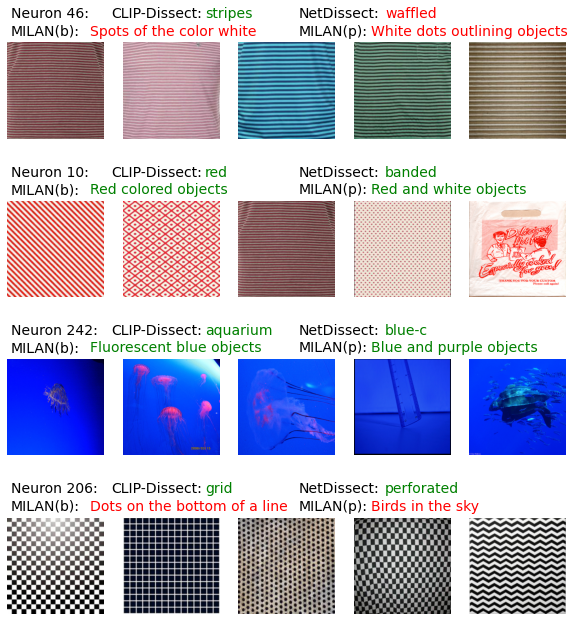

In [6]:
get_color = fig_1_7_8_colorings.get_coloring(target_name, target_layer, neurons_to_display)

name_conversion = {'resnet50':'resnet50_imagenet', 'resnet18_places':'resnet18_places365'}
ood_names = {'resnet50':'p', 'resnet18_places': 'i'}
netdissect_res = pd.read_csv('data/NetDissect_results/{}_{}.csv'.format(name_conversion[target_name],
                                                                       target_layer))

nd_ious = netdissect_res['score'].values
nd_labels = netdissect_res['label'].values

milan_base = pd.read_csv('data/MILAN_results/m_base_{}.csv'.format(name_conversion[target_name]))
if target_name == 'resnet50':
    milan_ood = pd.read_csv('data/MILAN_results/m_places365_{}.csv'.format(name_conversion[target_name]))
elif target_name == 'resnet18_places':
    milan_ood = pd.read_csv('data/MILAN_results/m_imagenet_{}.csv'.format(name_conversion[target_name]))
    
milan_base = milan_base[milan_base['layer']==target_layer]
milan_base = milan_base.sort_values(by=['unit'])
milan_base = list(milan_base['description'])

milan_ood = milan_ood[milan_ood['layer']==target_layer]
milan_ood = milan_ood.sort_values(by=['unit'])
milan_ood = list(milan_ood['description'])

if neurons_to_display == "CLIP-Dissect":
    ids_to_check = torch.sort(torch.max(similarity, dim=1)[0], descending=True)[1][0:10]
elif neurons_to_display == "NetDissect":
    ids_to_check = torch.sort(torch.tensor(nd_ious), descending=True)[1][:10]
elif neurons_to_display == "random":
    if target_layer == "layer4":
        ids_to_check = [1203, 1731, 683, 185]
    elif target_layer == "layer1":
        ids_to_check = [46, 10, 242, 206]

font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(ids_to_check)*2.2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(ids_to_check), ncols=1)
for j, orig_id in enumerate(ids_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size, color=get_color("clip", j))
    subfig.text(0.53 ,0.96, "NetDissect:", size=font_size)
    subfig.text(0.65 ,0.96, nd_labels[orig_id], size=font_size, color=get_color("nd", j))
    
    subfig.text(0.13, 0.85, "MILAN(b):", size=font_size)
    subfig.text(0.24, 0.85, milan_base[orig_id], size=font_size, color=get_color("milan_b", j))
    
    subfig.text(0.53, 0.85, "MILAN({}):".format(ood_names[target_name]), size=font_size)
    subfig.text(0.63, 0.85, milan_ood[orig_id], size=font_size, color=get_color("milan_ood", j))
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
    #fig.tight_layout()
plt.show()